# Задача 3. Реализация поиска кратчайших путей

In [1]:
!sudo add-apt-repository ppa:graphblas/graphblas
!sudo apt-get update
!sudo apt-get install libgraphblas1
!pip install python-graphblas[default]


ERROR: ppa 'graphblas/graphblas' not found (use --login if private)
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,858 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/univers

## Задача №1

Везде считаем, что вершины графа занумерованы подряд с нуля. Обратите внимание на то, что про граф заранее не известно, есть ли в нём циклы отрицательного веса.

 Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины SSSP(Bellman–Ford).
 - Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины.
 - Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring

import time
import sys
import random
from graphblas.io import mmread

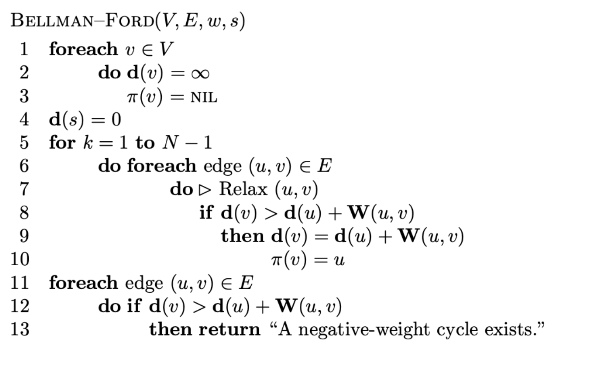

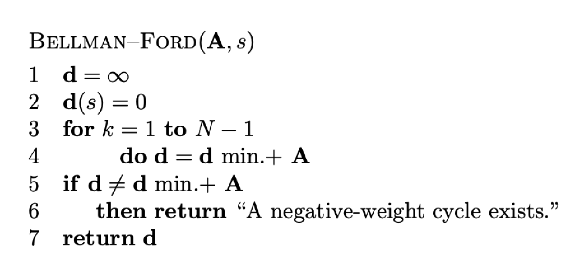

In [34]:
def SSSP(A, source):
    n = A.nrows
    v = Vector(A.dtype, A.nrows)  # Инициализация вектора расстояний
    v[source] << 0  # Расстояние до самой себя равно 0
    w = v.dup()  # Копия вектора расстояний

    for k in range(n-1):  # Выполняем n-1 итерацию
        w_old = w.dup()  # Сохраняем предыдущие значения
        w(binary.min) << w.vxm(A, semiring.min_plus)  # Обновляем значения расстояний
        if w.isequal(w_old):  # Если расстояния не изменились, то прерываем цикл
            break

    # Проверка на наличие отрицательных циклов
    for i in range(n):
        if w[i].value is not None and w[i].value < 0:
            raise Exception("Ошибка: в графе есть цикл отрицательного веса")

    # Формирование вывода
    output = []
    for i in range(n):
        output.append((i, float('inf') if w[i].value is None else w[i].value))

    return output


### Проверка 1

При обходе из вершины 0:
- до 0 кратчайший - 0
- до 1 кратчайший - 2
- до 2 кратчайший - 6
- до 3 кратчайший - 3
- до 4 кратчайший - 9
- до 5 кратчайший - 7
- до 6 кратчайший - 6


In [35]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)

start_vertices = 0

SSSP(m, start_vertices)

[(0, 0), (1, 2), (2, 6), (3, 3), (4, 9), (5, 7), (6, 6)]

Все ок!

Еще проверим 4-ую вершину, так как от нее есть пути с бесконечностью:

При обходе из вершины 4:
- до 0 кратчайший - inf
- до 1 кратчайший - inf
- до 2 кратчайший - 8
- до 3 кратчайший - inf
- до 4 кратчайший - 0
- до 5 кратчайший - 7
- до 6 кратчайший - inf


In [9]:
start_vertices = 4

SSSP(m, start_vertices)

[(0, inf), (1, inf), (2, 8), (3, inf), (4, 0), (5, 7), (6, inf)]

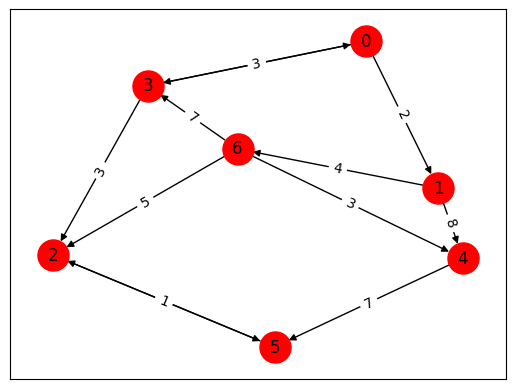

In [ ]:
gb.viz.draw(m)

### Проверка 2

In [87]:
data = [
    [0, 1, 2, 3],
    [1, 2, 3, 0],
    [1, -1, -1, -1],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
start_vertices = 2


try:
    print(SSSP(m, start_vertices))
except Exception as e:
    print(str(e))

Ошибка: в графе есть цикл отрицательного веса


## Задача №2

Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
- Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [13]:
def MSSP(A, sources):
    n = A.nrows

    # Инициализация матрицы расстояний, с количеством строк равным количеству источников и количеством столбцов равным количеству вершин
    v = Matrix(A.dtype, len(sources), n)

    # Устанавливаем начальные расстояния от каждого источника до самого себя равными 0
    for i, source in enumerate(sources):
        v[i, source] << 0

    w = v.dup()

    for k in range(n-2):
        # Сохраняем текущие расстояния
        w_old = w.dup()
        w(binary.min) << w.mxm(A, semiring.min_plus) # Обновляем значения расстояний

        # Если расстояния не меняются, прерываем цикл
        if w.isequal(w_old):
            break

    # Проверка на наличие отрицательных циклов
    for i in range(len(sources)):
        for j in range(n):
            if w[i, j].value is not None and w[i, j].value < 0:
                raise Exception("Ошибка: в графе есть цикл отрицательного веса")

    # вывод
    output = []
    for i in range(len(sources)):
        distances = [float('inf') if w[i, j].value is None else w[i, j].value for j in range(n)]
        output.append((sources[i], distances))

    return output

### Проверка 1

In [79]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)

start_vertices = [1, 2]

MSSP(m, start_vertices)

[(1, [14, 0, 9, 11, 7, 10, 4]), (2, [inf, inf, 0, inf, inf, 1, inf])]

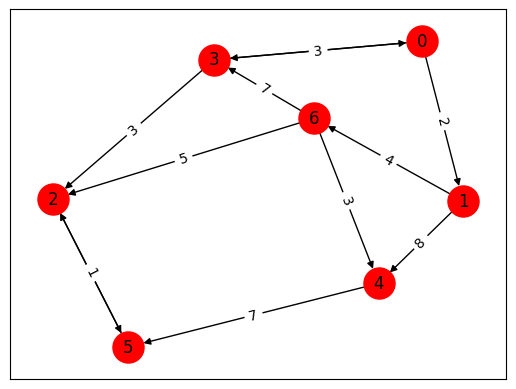

In [80]:
gb.viz.draw(m)

### Проверка 2

In [86]:
data = [
    [0, 1, 2, 3],
    [1, 2, 3, 0],
    [1, -1, -1, -1],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
start_vertices = [1, 2]


try:
    print(MSSP(m, start_vertices))
except Exception as e:
    print(str(e))

Ошибка: в графе есть цикл отрицательного веса


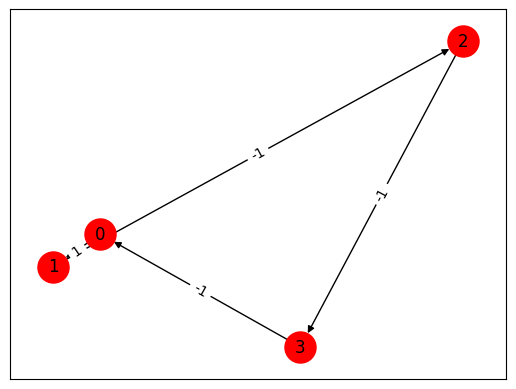

In [77]:
gb.viz.draw(m)

## Задача №3

Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания).
- Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно).
- Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

### Floyd–Warshall

In [14]:
import graphblas as gb
from graphblas import Matrix, semiring

def floyd_warshall(A):
    n = A.nrows
    dist = A.dup()  # Инициализируем матрицу расстояний исходной матрицей смежности

    # Устанавливаем диагональные элементы в 0
    for i in range(n):
        dist[i, i] << 0

    for k in range(n):
        for i in range(n):
            for j in range(n):
              dist_old = dist.dup()
              dist(binary.min) << dist.mxm(A, semiring.min_plus)
              if dist.isequal(dist_old):
                break

    # Проверка на наличие отрицательных циклов
    for i in range(n):
        if dist[i, i].value is not None and dist[i, i].value < 0:
            raise Exception("Ошибка: в графе есть цикл отрицательного веса")

    # Формирование вывода
    output = []
    for i in range(n):
        output.append((i, [float('inf') if dist[i, j].value is None else dist[i, j].value for j in range(n)]))

    return output

#### Проверка 1

In [46]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
print(floyd_warshall(m))

[(0, [0, 2, 6, 3, 9, 7, 6]), (1, [14, 0, 9, 11, 7, 10, 4]), (2, [inf, inf, 0, inf, inf, 1, inf]), (3, [3, 5, 3, 0, 12, 4, 9]), (4, [inf, inf, 8, inf, 0, 7, inf]), (5, [inf, inf, 1, inf, inf, 0, inf]), (6, [10, 12, 5, 7, 3, 6, 0])]


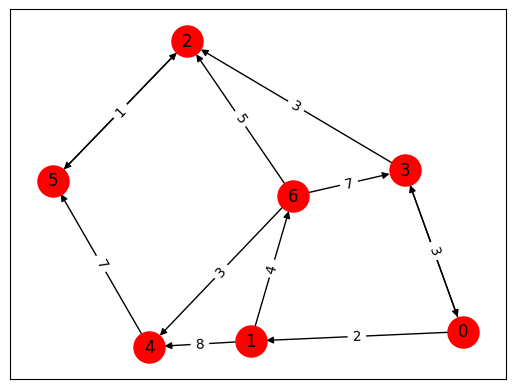

In [47]:
gb.viz.draw(m)

#### Проверка 2

In [48]:
data = [
    [0, 1, 2, 3],
    [1, 2, 3, 0],
    [1, -1, -1, -1],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)

try:
    print(floyd_warshall(m))
except Exception as e:
    print(str(e))

Ошибка: в графе есть цикл отрицательного веса


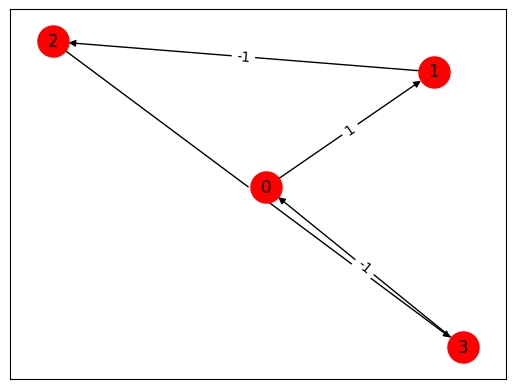

In [49]:
gb.viz.draw(m)

### Вычисление транзитивного замыкания

In [15]:
import numpy as np
from graphblas import Matrix, semiring, dtypes

def transitive_closure(A):
    n = A.nrows
    I = Matrix(dtypes.INT32, n, n)

    # Инициализация единичной матрицы
    for i in range(n):
        I[i, i] << 1

    D = A.dup()

    # Основной цикл Флойда-Уоршелла
    for k in range(n):
        D_old = D.dup()
        D(binary.min) << D.mxm(A, semiring.min_plus)
        D(binary.min) << D.ewise_add(I, binary.min) # Обновляем значения с учетом единичной матрицы
        if D.isequal(D_old):
            break

    # Проверка на наличие отрицательных циклов
    D_check = D.dup()
    D_check(binary.min) << D.mxm(A, semiring.min_plus)
    D_check(binary.min) << D_check.ewise_add(I, binary.min)
    if not D_check.isequal(D):
        raise Exception("Ошибка: в графе есть цикл отрицательного веса")

    # Формирование вывода
    output = {}
    for i in range(n):
        output[i] = [float('inf') if D[i, j].value is None else (0 if i == j else D[i, j].value) for j in range(n)]

    return output

#### Проверка 1

In [51]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)

print(transitive_closure(m))

{0: [0, 2, 6, 3, 9, 7, 6], 1: [14, 0, 9, 11, 7, 10, 4], 2: [inf, inf, 0, inf, inf, 1, inf], 3: [3, 5, 3, 0, 12, 4, 9], 4: [inf, inf, 8, inf, 0, 7, inf], 5: [inf, inf, 1, inf, inf, 0, inf], 6: [10, 12, 5, 7, 3, 6, 0]}


#### Проверка 2


In [52]:
data = [
    [0, 1, 2, 3],
    [1, 2, 3, 0],
    [1, -1, -1, -1],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)

try:
    print(transitive_closure(m))
except Exception as e:
    print(str(e))

Ошибка: в графе есть цикл отрицательного веса


## Еще больше проверок

In [10]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)

#### MSSP и SSSP

In [48]:
print('SSSP:\n', SSSP(m, 1), SSSP(m, 2), SSSP(m, 3),  sep='\n')
print('\n')
print('MSSP:\n')
for row in MSSP(m, [1,2,3]):
    print(row)

SSSP:

[(0, 14), (1, 0), (2, 9), (3, 11), (4, 7), (5, 10), (6, 4)]
[(0, inf), (1, inf), (2, 0), (3, inf), (4, inf), (5, 1), (6, inf)]
[(0, 3), (1, 5), (2, 3), (3, 0), (4, 12), (5, 4), (6, 9)]


MSSP:

(1, [14, 0, 9, 11, 7, 10, 4])
(2, [inf, inf, 0, inf, inf, 1, inf])
(3, [3, 5, 3, 0, 12, 4, 9])


Цифры те же)

#### Флойд Воршал и Тразитивное замыкание

In [63]:
assert (floyd_warshall(m)[0][1] == transitive_closure(m)[0])
assert (floyd_warshall(m)[1][1] == transitive_closure(m)[1])
assert (floyd_warshall(m)[2][1] == transitive_closure(m)[2])
assert (floyd_warshall(m)[3][1] == transitive_closure(m)[3])
assert (floyd_warshall(m)[4][1] == transitive_closure(m)[4])
assert (floyd_warshall(m)[5][1] == transitive_closure(m)[5])
assert (floyd_warshall(m)[6][1] == transitive_closure(m)[6])
print('Проверки пройдены!')

Проверки пройдены!


## Задача №4 + 3 балла

(+3 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

In [64]:
graph_names = ['GD00_a.mtx', 'Harvard500.mtx', 'ibm32.mtx']


In [65]:
import time

def measure_sssp_time(m, sources):
    print('SSSP_time:')
    start_time = time.time()
    [SSSP(m, source) for source in sources]
    end_time = time.time()
    print(f"Время выполнения: {end_time - start_time} секунд")

def measure_mssp_time(m, sources):
    print('MSSP_time:')
    start_time = time.time()
    MSSP(m, sources)
    end_time = time.time()
    print(f"Время выполнения: {end_time - start_time} секунд")

def measure_floyd_warshall_time(m):
    print('Флойд-Уоршелл:')
    start_time = time.time()
    floyd_warshall(m)
    end_time = time.time()
    print(f"Время выполнения: {end_time - start_time} секунд")

def measure_transitive_closure_time(m):
    print('Транзитивное замыкание:')
    start_time = time.time()
    transitive_closure(m)
    end_time = time.time()
    print(f"Время выполнения: {end_time - start_time} секунд")


In [72]:
def vertex_generate(n, p):
    population = range(n)
    vertex_array = random.sample(population, round(n * p))
    return np.array(vertex_array)

In [68]:
# Сравнение

gen_vertex = [0.01, 0.05, 0.1, 0.5] # доля генерируемых вершин
for graph_name in graph_names:
    graph = mmread(f'{graph_name}')
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Доля стартовых вершин:', p)
        print(measure_sssp_time(graph, vertex))
        print(measure_mssp_time(graph, vertex))

Количество вершин: 352 Количество ребер: 458
Доля стартовых вершин: 0.01
SSSP_time:
Время выполнения: 0.1650078296661377 секунд
None
MSSP_time:
Время выполнения: 0.10505056381225586 секунд
None
Доля стартовых вершин: 0.05
SSSP_time:
Время выполнения: 0.6926555633544922 секунд
None
MSSP_time:
Время выполнения: 1.0641098022460938 секунд
None
Доля стартовых вершин: 0.1
SSSP_time:
Время выполнения: 1.1189534664154053 секунд
None
MSSP_time:
Время выполнения: 0.9091837406158447 секунд
None
Доля стартовых вершин: 0.5
SSSP_time:
Время выполнения: 4.841740131378174 секунд
None
MSSP_time:
Время выполнения: 6.2089338302612305 секунд
None
Количество вершин: 500 Количество ребер: 2636
Доля стартовых вершин: 0.01
SSSP_time:
Время выполнения: 0.2781069278717041 секунд
None
MSSP_time:
Время выполнения: 0.3664662837982178 секунд
None
Доля стартовых вершин: 0.05
SSSP_time:
Время выполнения: 1.4230139255523682 секунд
None
MSSP_time:
Время выполнения: 1.8223881721496582 секунд
None
Доля стартовых вершин: 

In [73]:
def sssp_time(m, sources):
    print('Bellman_Ford:')
    %timeit (SSSP(m, n) for n in sources)

def mssp_time(m, sources):
    print('Bellman_Ford2:')
    %timeit MSSP(m, sources)

def floyd_warshall_time(m):
    print('Floyd Warshall:')
    %timeit floyd_warshall(m)

def transitive_closure_time(m):
    print('Транзитивного Замыкания:')
    %timeit transitive_closure(m)

In [70]:
# Сравнение

gen_vertex = [0.01, 0.05, 0.1, 0.5]
for graph_name in graph_names:
    graph = mmread(f'{graph_name}')
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Доля стартовых вершин:', p)
        print(sssp_time(graph, vertex))
        print(mssp_time(graph, vertex))

Количество вершин: 352 Количество ребер: 458
Доля стартовых вершин: 0.01
Bellman_Ford:
664 ns ± 179 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
146 ms ± 80.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Доля стартовых вершин: 0.05
Bellman_Ford:
383 ns ± 8.26 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
655 ms ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Доля стартовых вершин: 0.1
Bellman_Ford:
389 ns ± 4.39 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
964 ms ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Доля стартовых вершин: 0.5
Bellman_Ford:
466 ns ± 142 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
5.1 s ± 516 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 500 Количество ребер: 2636
Доля стартовых вершин: 0.01
Bellman_Ford:
381 ns ± 12 ns per loop (mean ± s

In [87]:
vertex = [[1, 5], [10, 5, 85], [22, 53, 4, 51]]

for graph_name in graph_names:
    graph = mmread(graph_name)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    for num in vertex:
        valid_sources = [n for n in num if n < graph.nrows]
        print('Количество стартовых вершин:', len(valid_sources))
        try:
            print(mssp_time(graph, valid_sources))
        except IndexError as e:
            print(f"Ошибка: {e}")

Количество вершин: 352 Количество ребер: 458
Количество стартовых вершин: 2
Bellman_Ford2:
152 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 3
Bellman_Ford2:
98 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 4
Bellman_Ford2:
117 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 500 Количество ребер: 2636
Количество стартовых вершин: 2
Bellman_Ford2:
169 ms ± 42.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 3
Bellman_Ford2:
205 ms ± 6.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 4
Bellman_Ford2:
277 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 32 Количество ребер: 126
Количество стартовых вершин: 2
Bellman_Ford2:
15.3 ms ± 6.65 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых верш

### Тестирование на случайных графах

In [88]:
def generate_graph(num_vertices, edge_density):
    matrix = gb.Matrix(int, num_vertices, num_vertices)  # Создаем пустую матрицу

    # Ограничение на количество итераций
    while edge_density > 0:

        # Генерация случайных чисел для матрицы смежности в интервале от 0 до количества вершин - 1
        row_idx = random.randint(0, num_vertices - 1)
        col_idx = random.randint(0, num_vertices - 1)

        # Проверка, что для данной ячейки еще не генерировались значения
        if matrix.get(row_idx, col_idx) is None and row_idx != col_idx:

            # Заполнение матрицы смежности - записываем случайный вес в ячейку
            # с только что сгенерированными числами и в смежную ей ячейку
            weight = random.randint(1, 10)
            matrix[row_idx, col_idx] = weight
            matrix[col_idx, row_idx] = weight
            edge_density -= 1

    return matrix

In [96]:
# Количество строк и плотности графов
num_rows = 10
edge_densities = [45, 33, 22, 11]
proportions_of_vertices = [0.1, 0.3, 0.5, 0.75, 1.0]  # Доля генерируемых вершин

for density in edge_densities:
    graph = generate_graph(num_rows, density)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    print(floyd_warshall_time(graph))
    print(transitive_closure_time(graph))
    for proportion in proportions_of_vertices:
        vertices = vertex_generate(graph.nrows, proportion)
        print('Количество стартовых вершин:', round(graph.nrows * proportion))
        print(sssp_time(graph, vertices))
        print(mssp_time(graph, vertices))

Количество вершин: 10 Количество ребер: 90
Floyd Warshall:
38 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Транзитивного Замыкания:
10 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 1
Bellman_Ford:
368 ns ± 6.35 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
3.05 ms ± 606 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 3
Bellman_Ford:
429 ns ± 113 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
6.02 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 5
Bellman_Ford:
364 ns ± 11.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
12.4 ms ± 3.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford:
The slowest run took 4.07 times longer than the fastest. This could mean th

In [95]:
# Параметры графа и доля генерируемых вершин
num_rows = 10
edge_densities = [43, 33, 22, 11]
proportions_of_vertices = [0.75, 0.85, 1.0]  # Доля генерируемых вершин
initial_vertex = [1]

for density in edge_densities:
    graph = generate_graph(num_rows, density)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    for proportion in proportions_of_vertices:
        print('Количество стартовых вершин:', round(graph.nrows * proportion))
        print(mssp_time(graph, vertex_generate(graph.nrows, proportion)))


Количество вершин: 10 Количество ребер: 86
Количество стартовых вершин: 8
Bellman_Ford2:
16.5 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford2:
16.4 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford2:
19.9 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 Количество ребер: 66
Количество стартовых вершин: 8
Bellman_Ford2:
15.6 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford2:
15.5 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford2:
20.6 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 10 Количество ребер: 44
Количество стартовых вершин: 8
Bellman_Ford2:
16.8 ms ± 3.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количеств

In [97]:
rows = 50
density = [1100, 900, 600, 300]
gen_vertex = [0.1, 0.3, 0.5, 0.75, 1] # доля генерируемых вершин
vertex = [1]

for den in density:
    graph = generate_graph(rows, den)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    print(floyd_warshall_time(graph))
    print(transitive_closure_time(graph))
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Количество стартовых вершин:', round(graph.nrows * p))
        print(sssp_time(graph, vertex))
        print(mssp_time(graph, vertex))

Количество вершин: 50 Количество ребер: 2200
Floyd Warshall:
2.34 s ± 448 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Транзитивного Замыкания:
321 ms ± 97.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 5
Bellman_Ford:
564 ns ± 119 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached.
87.8 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 15
Bellman_Ford:
571 ns ± 125 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
None
Bellman_Ford2:
165 ms ± 46.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 25
Bellman_Ford:
The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
1.16 µs ± 642 ns per loop (mean ± std. dev. of 7 runs, 1000

In [98]:
# Параметры графа на 50 строк и доля генерируемых вершин
num_rows = 50
edge_densities = [1200, 900, 600, 300]
proportions_of_vertices = [0.75, 0.85, 1.0]  # Доля генерируемых вершин
initial_vertex = [1]

for density in edge_densities:
    graph = generate_graph(num_rows, density)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)

    for proportion in proportions_of_vertices:
        print('Количество стартовых вершин:', round(graph.nrows * proportion))
        print(mssp_time(graph, vertex_generate(graph.nrows, proportion)))


Количество вершин: 50 Количество ребер: 2400
Количество стартовых вершин: 38
Bellman_Ford2:
330 ms ± 8.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
Bellman_Ford2:
368 ms ± 4.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford2:
578 ms ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 Количество ребер: 1800
Количество стартовых вершин: 38
Bellman_Ford2:
330 ms ± 7.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
Bellman_Ford2:
369 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford2:
435 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 Количество ребер: 1200
Количество стартовых вершин: 38
Bellman_Ford2:
468 ms ± 93.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин:

In [99]:
# 100 строк
rows = 100
density = [5000, 3500, 2500, 1250]
gen_vertex = [0.1, 0.3, 0.5, 0.75, 1]
vertex = [1]

for den in density:
    graph = generate_graph(rows, den)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    print(floyd_warshall_time(graph))
    print(transitive_closure_time(graph))
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Количество стартовых вершин:', round(graph.nrows * p))
        print(sssp_time(graph, vertex))
        print(mssp_time(graph, vertex))

KeyboardInterrupt: 

In [ ]:
# Параметры графа на 100 строк и доля генерируемых вершин
num_rows = 100
edge_densities = [5000, 3500, 2500, 1250]
proportions_of_vertices = [0.75, 0.85, 1.0]  # Доля генерируемых вершин
initial_vertex = [1]

for density in edge_densities:
    graph = generate_graph(num_rows, density)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)

    for proportion in proportions_of_vertices:
        print('Количество стартовых вершин:', round(graph.nrows * proportion))
        print(mssp_time(graph, vertex_generate(graph.nrows, proportion)))

## Вывод

Исследование реальных графов показало, что алгоритм Беллмана-Форда для мультивершин (MSSP) превосходит традиционный подход (SSSP) по эффективности при работе с крупными графами и несколькими стартовыми вершинами. Однако, на больших графах с одной стартовой вершиной классический алгоритм по-прежнему остается более быстрым.

При тестировании на случайно сгенерированных графах было установлено, что для небольших графов (до 100 вершин) классический алгоритм демонстрирует лучшую производительность, вне зависимости от количества стартовых вершин. Разреженность графа практически не влияет на эффективность алгоритмов. Даже если использовать 100% вершин в качестве стартовых, улучшенный алгоритм Беллмана-Форда все равно немного уступает классическому по времени выполнения.

Когда доля стартовых вершин в графе достигает 40-50%, лучше применять алгоритмы для поиска кратчайших путей между всеми парами вершин, такие как Флойд-Уоршалл или транзитивное замыкание. Эти алгоритмы имеют более высокую асимптотическую сложность, но при большом числе стартовых вершин работают быстрее, чем улучшенный Беллман-Форд. Тем не менее, при меньших долях стартовых вершин улучшенный Беллман-Форд демонстрирует лучшие результаты, особенно при наличии нескольких стартовых точек.

### Задача №5

In [100]:
def modified_Bellman_Ford(A, start_vertex, threshold=0.0):
    # Изначально устанавливаем порог в 0 (по умолчанию используется push)
    num_vertices = A.nrows
    distances = Vector(dtypes.INT64, num_vertices)
    distances[start_vertex] << 0
    temp_distances = distances.dup()

    for _ in range(num_vertices - 1):
        previous_distances = temp_distances.dup()

        # push
        if threshold == 0.0:
            temp_distances(binary.min) << temp_distances.vxm(A, semiring.min_plus)

        # pull
        elif threshold == 1.0:
            temp_distances(binary.min) << A.T.mxv(temp_distances, semiring.min_plus)

        # смешанный режим
        else:
            if temp_distances.nvals / temp_distances.size > threshold:
                temp_distances(binary.min) << A.T.mxv(temp_distances, semiring.min_plus)
            else:
                temp_distances(binary.min) << temp_distances.vxm(A, semiring.min_plus)

        if temp_distances.isequal(previous_distances):
            break

    previous_distances = temp_distances.dup()
    # push
    if threshold == 0.0:
        temp_distances(binary.min) << temp_distances.vxm(A, semiring.min_plus)

    # pull
    elif threshold == 1.0:
        temp_distances(binary.min) << A.T.mxv(temp_distances, semiring.min_plus)

    # смешанный режим
    else:
        if temp_distances.nvals / temp_distances.size > threshold:
            temp_distances(binary.min) << A.T.mxv(temp_distances, semiring.min_plus)
        else:
            temp_distances(binary.min) << temp_distances.vxm(A, semiring.min_plus)

    if not temp_distances.isequal(previous_distances):
        return "ВНИМАНИЕ: Обнаружен цикл отрицательного веса"

    result = Vector(dtypes.FP64, num_vertices)
    for i in range(num_vertices):
        if temp_distances[i].value is None:
            result[i] << float('inf')
        else:
            result[i] << temp_distances[i]
    return result

In [101]:
def multi_source_Bellman_Ford(A, start_vertices, threshold=0.0):
    # Устанавливаем порог по умолчанию на 0 (по умолчанию используется push)
    num_columns = A.ncols
    num_start_vertices = len(start_vertices)
    distances_matrix = Matrix(dtypes.INT64, num_start_vertices, num_columns)
    for index, vertex in enumerate(start_vertices):
        distances_matrix[index, vertex] << 0
    temp_matrix = distances_matrix.dup()

    for _ in range(num_columns - 1):
        previous_matrix = temp_matrix.dup()
        for i in range(num_start_vertices):

            # push
            if threshold == 0.0:
                temp_matrix[i, :](binary.min) << temp_matrix[i, :].vxm(A, semiring.min_plus)

            # pull
            elif threshold == 1.0:
                temp_matrix[i, :](binary.min) << A.T.mxv(temp_matrix[i, :], semiring.min_plus)

            # смешанный режим
            else:
                if temp_matrix[i, :].nvals / temp_matrix[i, :].size > threshold:
                    temp_matrix[i, :](binary.min) << A.T.mxv(temp_matrix[i, :], semiring.min_plus)
                else:
                    temp_matrix[i, :](binary.min) << temp_matrix[i, :].vxm(A, semiring.min_plus)

        if temp_matrix.isequal(previous_matrix):
            break

    previous_matrix = temp_matrix.dup()
    for i in range(num_start_vertices):

        # push
        if threshold == 0.0:
            temp_matrix[i, :](binary.min) << temp_matrix[i, :].vxm(A, semiring.min_plus)

        # pull
        elif threshold == 1.0:
            temp_matrix[i, :](binary.min) << A.T.mxv(temp_matrix[i, :], semiring.min_plus)

        # смешанный режим
        else:
            if temp_matrix[i, :].nvals / temp_matrix[i, :].size > threshold:
                temp_matrix[i, :](binary.min) << A.T.mxv(temp_matrix[i, :], semiring.min_plus)
            else:
                temp_matrix[i, :](binary.min) << temp_matrix[i, :].vxm(A, semiring.min_plus)

    if not temp_matrix.isequal(previous_matrix):
        return "ВНИМАНИЕ: Обнаружен цикл отрицательного веса"

    result = Matrix(dtypes.FP64, num_start_vertices, num_columns)
    for i in range(num_start_vertices):
        for j in range(num_columns):
            if temp_matrix[i, j].value is None:
                result[i, j] << float('inf')
            else:
                result[i, j] << temp_matrix[i, j]
    return result

In [102]:
def create_random_graph(num_vertices, density):
    adj_matrix = np.zeros((num_vertices, num_vertices))
    for i in range(num_vertices):
        for j in range(i, num_vertices):
            if np.random.rand() < density:
                adj_matrix[i, j] = 1
    np.fill_diagonal(adj_matrix, 0)
    adj_matrix += adj_matrix.T
    adj_matrix = Matrix.from_dense(adj_matrix, missing_value=0.0)
    return adj_matrix

In [103]:
graph = create_random_graph(1000, 0.4)
for threshold in [0.0, 0.1, 0.3, 0.7, 1.0]:  # уровень порога
    print(f'Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень threshold: {threshold}')
    print(f'nvals: {graph.nvals}, nrows: {graph.nrows}, ncols: {graph.ncols}')
    %timeit multi_source_Bellman_Ford(graph, range(0, 20), threshold)
    print()

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень threshold: 0.0
nvals: 399958, nrows: 1000, ncols: 1000
3.36 s ± 596 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень threshold: 0.1
nvals: 399958, nrows: 1000, ncols: 1000
3.39 s ± 600 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень threshold: 0.3
nvals: 399958, nrows: 1000, ncols: 1000
3.43 s ± 674 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень threshold: 0.7
nvals: 399958, nrows: 1000, ncols: 1000
3.44 s ± 584 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень threshold: 1.0
nvals: 399958, nrows: 1000, ncols: 1000
3.43 s ± 371 ms per loop (mean ± std. dev. 

In [104]:
graph = create_random_graph(1000, 0.4)
for threshold in [0.0, 0.1, 0.3, 0.7, 1.0]:
    print(f'Количество вершин: 1000, плотность: 0.4, уровень threshold: {threshold}')
    print(f'nvals: {graph.nvals}, nrows: {graph.nrows}, ncols: {graph.ncols}')
    %timeit modified_Bellman_Ford(graph, np.random.randint(0, graph.nrows), threshold)
    print()

Количество вершин: 1000, плотность: 0.4, уровень threshold: 0.0
nvals: 398618, nrows: 1000, ncols: 1000
144 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень threshold: 0.1
nvals: 398618, nrows: 1000, ncols: 1000
146 ms ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень threshold: 0.3
nvals: 398618, nrows: 1000, ncols: 1000
125 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень threshold: 0.7
nvals: 398618, nrows: 1000, ncols: 1000
228 ms ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, уровень threshold: 1.0
nvals: 398618, nrows: 1000, ncols: 1000
191 ms ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



### Вывод

Вывод по поводу модифицированного алгоритма Беллмана-Форда (mssp) с оптимизацией push/pull:

Результаты тестирования показывают, что время выполнения модифицированного алгоритма Беллмана-Форда незначительно зависит от уровня оптимизации push/pull. Для графа с плотностью 0.4 и 20 стартовыми вершинами время выполнения варьируется от 3.36 до 3.44 секунд при различных уровнях оптимизации. Наиболее быстрое время было зафиксировано при уровне push/pull 0.0, но разница с другими уровнями несущественна.

Таким образом, оптимизация push/pull не оказывает значительного влияния на производительность модифицированного алгоритма Беллмана-Форда в данном случае.

Вывод по поводу алгоритма Беллмана-Форда (sssp) с push/pull:
Анализ времени выполнения алгоритма Беллмана-Форда с случайно выбранной стартовой вершиной показывает, что время выполнения варьируется в зависимости от уровня оптимизации push/pull, но эти изменения незначительны. В среднем время выполнения составляет около 125-228 миллисекунд. Наиболее быстрое время было достигнуто при уровне push/pull 0.3, но разница с другими уровнями также несущественна.

Следовательно, можно сделать вывод, что оптимизация push/pull не оказывает значительного влияния на время выполнения алгоритма Беллмана-Форда, хотя в отдельных случаях может наблюдаться небольшое улучшение или ухудшение производительности.